# SFR and Metallicities for Gemini Galaxies in CGM$^2$ Survey

In [1]:
%matplotlib inline

from astropy.io import fits
from astropy.table import Table
from glob import glob
import astropy.units as u
import astropy.constants as co
import astropy.cosmology as cosm
import numpy as np
import pandas as pd
import os

from os.path import expanduser

import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap

In [2]:
plt.style.use('ggplot')

In [3]:
# grabs galaxyinfo file from whatever location in dropbox that it happens to be in (note:
# for this to work it does need to be in the dropbox somewhere and also don't rename the file!)

home = expanduser('~')
path = os.path.join(home,'Dropbox','**','galaxyinfo - galaxyinfo_old.*')
filepath = glob(path, recursive=True)
vetrr = pd.read_csv(filepath[0])

In [4]:
# going with basic LCDM for consistency's sake:

cosmos = cosm.FlatLambdaCDM(70, 0.3, Tcmb0=2.725*u.K)

# SFR function:

In [5]:
def SFR_Halpha(Ha_flux, z):
    
    '''
    Gives SFR in M_sun/year.
    Assumes Halpha flux by default so make sure to multiply by 2.86 if using for Hbeta.
    inputs:
    Ha_flux = float64, doesn't need dimensions.
    z = float64
    Returns:
    SFR = float64
    '''
    Ha_flux = Ha_flux*u.cgs.erg/(u.cm**2*u.s)
    distance = cosmos.luminosity_distance(z) # will have units of Mpc
    L = Ha_flux*4*np.pi*distance**2
    L = L.to(u.cgs.erg/u.s)
    SFR = 7.9e-42*L.value
        
    return(SFR)

In [6]:
# Empty list for storing SFR + flags:
sfr = np.empty([len(vetrr[:]),2])

for ii in range(len(vetrr[:])):
    # Gets Halpha SFR if reliable flux present:
    if vetrr.Halpha_flux.loc[ii] != np.nan and vetrr.Halpha_flux.loc[ii] > -98 and vetrr.Halpha_LQ.loc[ii] == 1:
        HalphaSFR = SFR_Halpha(vetrr.Halpha_flux.loc[ii], vetrr.z.loc[ii])
        sfr[ii] = [HalphaSFR, 1]
    # Gets Hbeta SFR if Halpha not present but Hbeta flux is:
    elif vetrr.Hbeta_flux.loc[ii] != np.nan and vetrr.Hbeta_flux.loc[ii] > -98 and vetrr.Hbeta_LQ.loc[ii] == 1:
        HbetaSFR = SFR_Halpha(vetrr.Hbeta_flux.loc[ii]*2.86, vetrr.z.loc[ii])
        sfr[ii] = [HbetaSFR, 2]
    # Assigns value of -99 and quality flag of 0 in the case where neither H_a/H_B is present and reliable:
    else:
        sfr[ii] = [-99, 0]

In [7]:
# gathering the successfully calculated SFRs and doing a bit of analysis on them:

all_killer_no_filler = sfr[np.where(sfr.T[0]!=-99)].T[0] # Okay so all I mean by this name is that it's
# just the entries from the sfr list where there's an actual value, i.e. only the interesting ones.

# here's some stats:
print(
    'mean',
    np.mean(all_killer_no_filler),
    'median',
    np.median(all_killer_no_filler),
    'max',
    np.max(all_killer_no_filler),
    'min',
    np.min(all_killer_no_filler),
'solar masses per year')

mean 0.6308037398229215 median 0.4075101293879423 max 6.864776708774299 min 0.0007033685789614294 solar masses per year


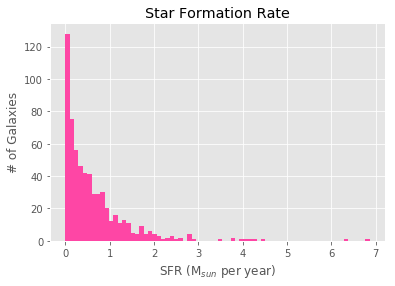

In [8]:
# Now for a plot of Halpha+Hbeta SFR:

plt.hist(all_killer_no_filler, bins=70, stacked=True, color='xkcd:Barbie Pink')
plt.xlabel('SFR (M$_{sun}$ per year)')
plt.ylabel('# of Galaxies')
plt.title('Star Formation Rate');

In [9]:
# Squish our new columns into the original dataframe (or a copy of it, anyway):

vetSFR = pd.DataFrame(data=vetrr, copy=True)

# adding in the new columns:

vetSFR['properSFR'] = sfr.T[0]
vetSFR['properSFR_flag'] = sfr.T[1]

# uncomment if you want a new copy of this particular array:

#vetSFR.to_csv('./py_files/SFR_info.csv', index=False)

## grabbing stellar masses:

In [10]:
# filepath for table containing stellar masses for all the galaxies that we've been working with:

path = os.path.join(home,'Dropbox','**','cgmsq_allsurveys_cgmsystable.fits')
massfilepath = glob(path, recursive=True)

In [11]:
# Extracts table from fits file and resolves various issues required to concatenate this new table (which Matt
# made at some point previously) with our new SFR info-containing table.

mass_and_friends = Table.read(massfilepath[-1])
mass_and_friends.remove_columns(['zRR', 'zRR_Err', 'spectype_rr'])
mass_and_friends = mass_and_friends.to_pandas()
mass_and_friends['id'] = mass_and_friends['id'].str.decode('utf-8') 

In [12]:
# merges mass table with initial (SFR-containing) one:

vetrrm = pd.merge(vetSFR, mass_and_friends, on=['id'], how='right')

# sorting out some (more) naming conflicts:

vetrrm.rename(columns={'z_x': 'z'}, inplace=True)

# adding log of SFR as well to save some time while plotting:

vetrrm['log_SFR'] = np.log10(vetrrm['properSFR'])

# for the same reason creating a specific star formation rate column as well:

vetrrm['SSFR'] = np.log10(vetrrm['SFR']/10**vetrrm['mstars'])

/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


# Metallicity function:

In [13]:
# arguments to be input into metallicity function:

m = vetrrm['mstars']
OIII = vetrrm['OIII_flux']
Hbeta = vetrrm['Hbeta_flux']
NII = vetrrm['NII_flux']
Ha = vetrrm['Halpha_flux']
OII = vetrrm['OII_flux']

OIIIflag = vetrrm['OIII_LQ']
Hbetaflag = vetrrm['Hbeta_LQ']
NIIflag = vetrrm['NII_LQ']
Haflag = vetrrm['Halpha_LQ']
OIIflag = vetrrm['OII_LQ']

# could streamline a bit by using this as the input for the function instead:

params = [OIII,Ha,NII,OII,Hbeta,m,OIIIflag,Haflag,NIIflag,OIIflag,Hbetaflag]

In [14]:
def metal(O3, Halpha, NII, OII, HB, mass, O3flag, Halphaflag, NIIflag, OIIflag, HBflag):
    """
    Gets Z where possible. If you have [OIII], the first two Balmers, and NII, there are up to 2 methods available.
    If you also have [OII] but are missing some of those others, you can use one of the R23 functions (implemented
    here as the functions upper/lowerbranch). This function's goal is to figure out which is appropriate for a 
    given galaxy and to output the results or lack thereof. Also outputs quality flags so that it's trivial 
    to select the ones where a certain type of metallicity was reliably calculated.
    
    Inputs:
    coming soon
    
    Returns:
    coming soon
    """
    # Programming Hard Mode: Write this without if statements.
    
    # part 1: defining things
    
    if O3 > -98 and HB > -98 and O3flag == 1 and HBflag == 1:
        O3HB = O3/HB
    else:
        O3HB = -99
        
    if NII > -98 and Halpha > -98 and NIIflag == 1 and Halphaflag == 1:
        N2 = NII/Halpha
    else:
        N2 = -99
        
    if O3HB > -98 and N2 > -98:
        O3N2 = np.log10(O3HB/N2)
    else:
        O3N2 = -99
    try:
        if OII > -98 and O3HB > -98 and OIIflag == '1':
            R23 = (OII/HB)+O3HB
            x = np.log10(R23)
            y = np.log10(1.3*O3/OII)
        else:
            R23 = -99
    except:
        if OII > -98 and O3HB > -98 and OIIflag == 1:
            R23 = (OII/HB)+O3HB
            x = np.log10(R23)
            y = np.log10(1.3*O3/OII)
        else:
            R23 = -99        
        
    # part 2: getting metallicities
    
    if O3N2 != -99 or N2 != -99:
        if O3N2 < 1.9 and O3N2 != -99:
            Z_N2 = 8.73-(0.32*O3N2)
            Z_N2flag = 1
        else:
            Z_N2 = 8.92+(0.57*np.log10(N2))
            Z_N2flag = 2
            
    if N2 == -99:
        Z_N2 = -99
        Z_N2flag = -99
    if R23 == -99:
        Z_R23 = -99
        Z_R23flag = -99
        
    if R23 != -99:
        # N2O2 (if present at all):
        if NII != -99 and NIIflag == 1 and OII != -99 and OIIflag ==1:
            N2O2 = NII/OII
            if np.log10(N2O2) > -1.2:
                Z_R23 = upper_branch(x,y)
                Z_R23flag = 2
        # N2 index:
        elif N2 != -99:
            if N2 > 0.1:
                Z_R23 = upper_branch(x,y)
                Z_R23flag = 1
        # mass:
        elif mass > 9 or mass < 8:
            if mass < 8:
                Z_R23 = lower_branch(x,y)
            if mass > 9:
                Z_R23 = upper_branch(x,y)
            Z_R23flag = 3
        # remains degenerate:
        else:
            Z_R23 = -99
            Z_R23flag = 0
            
    return(O3HB, N2, O3N2, R23, Z_N2, Z_N2flag, Z_R23, Z_R23flag)

In [17]:
# Our two R23 metallicity functions (w/ conditions determining their respective uses given above):
def lower_branch(x,y):
    '''
    inputs:
    x = log(R23)
    y = log(1.3*[OIII]5007/[OII])
    returns:
    Z = metallicity (12 + log(O/H))
    '''
    Z = 12.0 - 4.944 + 0.767*x + 0.602*x**2 - y*(0.29+0.332*x-0.331*x**2)
    
    return(Z)
def upper_branch(x,y):
    '''
    inputs:
    x = log(R23)
    y = log(1.3*[OIII]5007/[OII])
    returns:
    Z = metallicity (12 + log(O/H))
    '''
    Z = 12.0 - 2.939 - 0.2*x - 0.237*x**2 - 0.305*x**3 - 0.0283*x**4 - y*(
    0.0047 - 0.0221*x - 0.102*x**2 - 0.0817*x**3 - 0.00717*x**4)
    return(Z)    

In [18]:
# preparing a new table just for metallicities:

param_keys = ['O3HB', 'N2', 'O3N2', 'R23', 'Z_N2', 'Z_N2flag', 'Z_R23', 'Z_R23flag']
metal_returns = np.empty([len(vetrrm),len(param_keys)])

In [19]:
# calculating metallicities:
for ii in range(len(vetrrm)):
    metal_returns[ii] = metal(OIII[ii],Ha[ii],NII[ii],OII[ii],Hbeta[ii],m[ii],OIIIflag[ii],Haflag[ii],NIIflag[ii],OIIflag[ii],Hbetaflag[ii])

In [20]:
# naming columns and adding them to our big table w/ everything else:
for ii in range(len(param_keys)):
    vetrrm[param_keys[ii]] = metal_returns.T[ii]

# Plots:

In [21]:
# subsection of the main array consisting of galaxies we got an SFR for:

all_killer_no_filler = vetrrm.loc[np.where(vetrrm['properSFR']!=-99)]

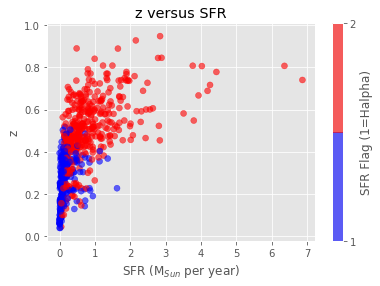

In [22]:
colormap = ListedColormap(['blue', 'red'])
plt.scatter(
    all_killer_no_filler['properSFR'], all_killer_no_filler['z'], c=all_killer_no_filler['properSFR_flag'], cmap=colormap, alpha=0.6
)
plt.xlabel('SFR (M$_{Sun}$ per year)')
plt.ylabel('z')
plt.colorbar(ticks=[1,2], label='SFR Flag (1=Halpha)')
plt.title('z versus SFR');

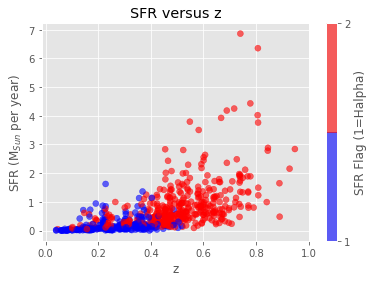

In [23]:
colormap = ListedColormap(['blue', 'red'])
plt.scatter(
    all_killer_no_filler['z'], all_killer_no_filler['properSFR'], c=all_killer_no_filler['properSFR_flag'], cmap=colormap, alpha=0.6
)
plt.xlabel('z')
plt.ylabel('SFR (M$_{Sun}$ per year)')
plt.colorbar(ticks=[1,2], label='SFR Flag (1=Halpha)')
plt.title('SFR versus z')
plt.savefig('./py_files/SFR_vs_z.png');

## Mass plots

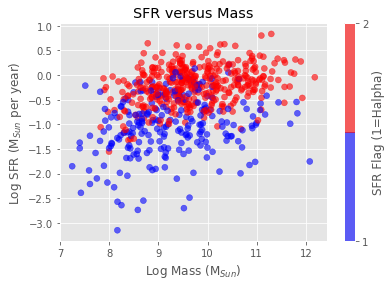

In [24]:
colormap = ListedColormap(['blue', 'red'])
plt.scatter(
    all_killer_no_filler['mstars'], all_killer_no_filler['log_SFR'], c=all_killer_no_filler['properSFR_flag'], cmap=colormap, alpha=0.6
)
plt.xlabel('Log Mass (M$_{Sun}$)')
plt.ylabel('Log SFR (M$_{Sun}$ per year)')
plt.colorbar(ticks=[1,2], label='SFR Flag (1=Halpha)')
plt.savefig('./py_files/SFRvsMass.png')
plt.title('SFR versus Mass');

#### Checking smallest SFR:

In [25]:
all_killer_no_filler['id'][np.where(all_killer_no_filler['properSFR']==np.min(all_killer_no_filler['properSFR']))[0]]

371    J105957.51+251418.8._01
Name: id, dtype: object

In [26]:
all_killer_no_filler['Hbeta_flux'][np.where(all_killer_no_filler['properSFR']==np.min(all_killer_no_filler['properSFR']))[0]]

371    1.640000e-17
Name: Hbeta_flux, dtype: float64

## Metallicity plots!

In [27]:
# To save some time while plotting, here are two sub-arrays containing just the entries from
# our main table where there was both a SFR and a metallicity (N2 and R23 respectively for hella_metal &
# more_metal).

hella_metal = vetrrm.loc[
    np.where(vetrrm['log_SFR']>-5) 
    and np.where(vetrrm['Z_N2flag']>-99)
]
more_metal = vetrrm.loc[
    np.where(vetrrm['log_SFR']>-5) 
    and np.where(vetrrm['Z_R23flag']>-99) 
]

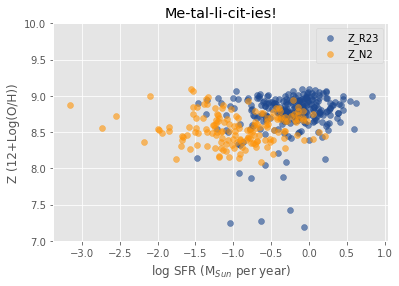

In [28]:
plt.scatter(more_metal['log_SFR'], more_metal['Z_R23'], c='xkcd:Cobalt', alpha=0.6, label='Z_R23')
plt.scatter(hella_metal['log_SFR'], hella_metal['Z_N2'], c='xkcd:Tangerine', alpha=0.6, label='Z_N2')
plt.xlabel('log SFR (M$_{Sun}$ per year)')
plt.ylabel('Z (12+Log(O/H))')
plt.ylim(7,10)
plt.legend()
plt.title('Me-tal-li-cit-ies!')
plt.savefig('./py_files/Z_vs_SFR');

In [29]:
len(more_metal)

316

Text(0.5, 1.0, 'ssfr versus Stellar Mass')

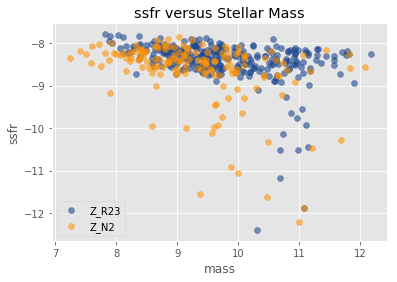

In [30]:
plt.scatter(more_metal['mstars'],more_metal['SSFR'], c='xkcd:Cobalt', alpha=0.6, label='Z_R23')
plt.scatter(hella_metal['mstars'],hella_metal['SSFR'], c='xkcd:Tangerine', alpha=0.6, label='Z_N2')
plt.xlabel('mass')
plt.ylabel('ssfr')
#plt.xlim(-9,-8)
#plt.ylim(7,10)
plt.legend()
plt.title('ssfr versus Stellar Mass')
#plt.savefig('./py_files/specSFR_vs_mass');

Text(0.5, 1.0, 'Z vs SSFR')

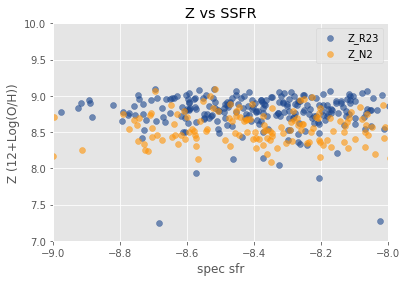

In [31]:
plt.scatter(more_metal['SSFR'], more_metal['Z_R23'], c='xkcd:Cobalt', alpha=0.6, label='Z_R23')
plt.scatter(hella_metal['SSFR'], hella_metal['Z_N2'], c='xkcd:Tangerine', alpha=0.6, label='Z_N2')
plt.xlabel('spec sfr')
plt.ylabel('Z (12+Log(O/H))')
plt.xlim(-9,-8)
plt.ylim(7,10)
plt.legend()
plt.title('Z vs SSFR')
#plt.savefig('./py_files/specSFR_vs_Z');

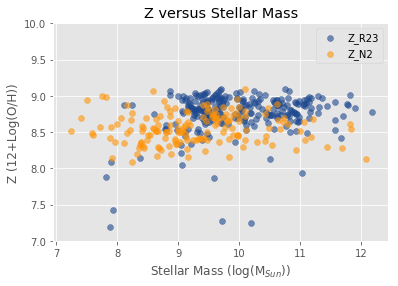

In [32]:
plt.scatter(more_metal['mstars'], more_metal['Z_R23'], c='xkcd:Cobalt', alpha=0.6, label='Z_R23')
plt.scatter(hella_metal['mstars'], hella_metal['Z_N2'], c='xkcd:Tangerine', alpha=0.6, label='Z_N2')
plt.xlabel('Stellar Mass (log(M$_{Sun}$))')
plt.ylabel('Z (12+Log(O/H))')
plt.ylim(7,10)
plt.legend()
plt.title('Z versus Stellar Mass')
plt.savefig('./py_files/Z_vs_M');

### BPT Diagrams!

In [33]:
BPTgallinex = np.arange(-2,0,0.1)
BPTgalline = 0.61/(BPTgallinex-0.05)+1.3

BPTqsolinex = np.arange(-2,0.5,0.1)
BPTqsoline = 0.61/(BPTqsolinex-0.47)+1.19

/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


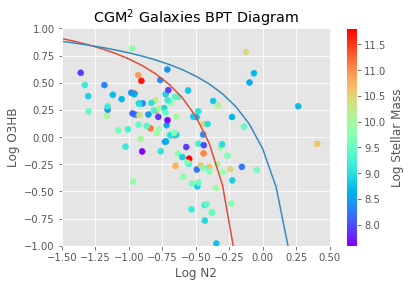

In [34]:
plt.scatter(np.log10(vetrrm['N2']), np.log10(vetrrm['O3HB']), c=vetrrm['mstars'], cmap='rainbow')
plt.plot(BPTgallinex,BPTgalline)
plt.plot(BPTqsolinex,BPTqsoline)
cb=plt.colorbar()
cb.set_label('Log Stellar Mass')
plt.xlabel('Log N2')
plt.ylabel('Log O3HB')
plt.xlim(-1.5,0.5)
plt.ylim(-1,1)
plt.title('CGM$^2$ Galaxies BPT Diagram')
plt.savefig('./py_files/BPTdiagram.png');

/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


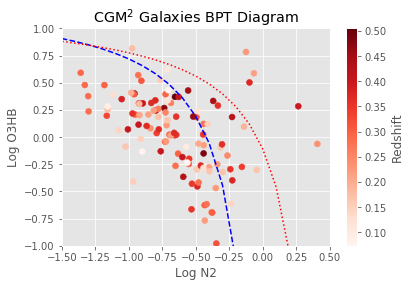

In [35]:
plt.scatter(np.log10(vetrrm['N2']), np.log10(vetrrm['O3HB']), c=vetrrm['z'], cmap='Reds')
plt.plot(BPTgallinex,BPTgalline, c='b', linestyle='--')
plt.plot(BPTqsolinex,BPTqsoline, c='r', linestyle=':')
cb=plt.colorbar()
cb.set_label('Redshift')
plt.xlabel('Log N2')
plt.ylabel('Log O3HB')
plt.xlim(-1.5,0.5)
plt.ylim(-1,1)
plt.title('CGM$^2$ Galaxies BPT Diagram')
plt.savefig('./py_files/BPTdiagramz.png');

## Gathering up the QSOs:

In [36]:
def QSOline(logN2):
    '''
    Function for line delineating QSOs from just maybe-QSOs in N2 BPT diagram.
    '''
    y = 0.61/(logN2-0.47)+1.19
    return(y)

In [37]:
# Finding the indices where the value of the galaxy's Log(O3HB) is above the AGN line:

log_N2 = np.log10(vetrrm['N2'])
log_O3HB = np.log10(vetrrm['O3HB'])
diff = log_O3HB-QSOline(log_N2)

np.where(diff>0)

/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


(array([ 20,  57, 126, 406, 431, 707]),)

In [38]:
# printing some of the more relevant information regarding our candidate AGN:

vetrrm['id'][np.ravel(np.where(diff>0))],vetrrm['rho'][np.ravel(np.where(diff>0))],vetrrm['z'][np.ravel(np.where(diff>0))]

(20     J022622.00+001642.3._01
 57     J084340.94+411529.3._06
 126    J091432.11+282103.7._03
 406    J111238.81+354054.8._21
 431    J113328.16+032717.6._07
 707    J155307.29+354825.1._11
 Name: id, dtype: object, 20     506.297617
 57     899.136141
 126    571.806417
 406    459.476283
 431     22.527790
 707    105.503471
 Name: rho, dtype: float64, 20     0.228233
 57     0.394573
 126    0.179274
 406    0.372795
 431    0.236691
 707    0.217867
 Name: z, dtype: float64)

In [39]:
vetrrm['mstars'][np.ravel(np.where(diff>0))]

20     10.438886
57      8.692991
126     9.839519
406     8.603573
431    10.624305
707     8.673651
Name: mstars, dtype: float64

# Note: there's a separate notebook for further analysis of the possible AGN. It's called `AGNvestigation.ipynb` and is also found in this directory.

In [40]:
#np.savez('CGM2galaxies.npz', CGM2galaxies=vetrrm)
vetrrm.to_csv('./py_files/CGM2galaxies.csv')